In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import gc
import time
import re
import s2_py as s2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
import pandas_profiling as pp
from shapely.geometry import Polygon, mapping, box
from datetime import date, timedelta

### Part 1. Read in CA coordinates

Source: https://catalog.data.gov/dataset/tiger-line-shapefile-2016-state-california-current-county-subdivision-state-based

In [4]:
# Change the location to where you downloaded CA_State folder (it's also in EDA/Data folder on GitHub)
ca_df = gpd.read_file("./Data/CA_State/CA_State_TIGER2016.shp")
# we need to change coordinates system 
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...


In [5]:
def extract_max_polygon(fire_poly):
    """Return the largest polygon for each multipolygon"""
    fire_map = mapping(fire_poly)
    if 'coordinates' in fire_map:
        coords = fire_map['coordinates']
    elif 'features' in fire_map:
        coords = fire_map['features'][0]['geometry']['coordinates']
    
    if len(coords) == 1:
        max_poly = coords[0]
    else:
        max_poly = coords[0][0]
        for i in range(len(coords)):
            if len(coords[i][0]) > len(max_poly):
                max_poly = coords[i][0]
    return max_poly

In [6]:
ca_df['Largest_polygon'] = ca_df.geometry.apply(extract_max_polygon)
ca_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Largest_polygon
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1..."


### Part 2. Read in Fire Zones

Source: https://www.weather.gov/gis/FireZones

In [7]:
fz_df = gpd.read_file("./Data/fz02ap19/fz02ap19.shp")
fz_df = fz_df[fz_df.STATE=='CA'].reset_index().drop(columns=['index'])
fz_df['AREA'] = fz_df.area
fz_df.shape

(108, 11)

In [8]:
fz_df.head()

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA
0,CA,227,VEF,Death Valley National Park,CA227,P,ee,-117.1739,36.4677,"POLYGON ((-117.83379364 37.46531295800003, -11...",2.001602
1,CA,270,REV,Surprise Valley California,CA270,P,nn,-120.0862,41.6116,"POLYGON ((-119.999298096 41.87491226200007, -1...",0.129737
2,CA,204,EKA,Lower Middle Klamath,CA204,P,nn,-123.5768,41.4252,"POLYGON ((-123.839914734 41.61329417200005, -1...",0.190186
3,CA,203,EKA,Upper Smith,CA203,P,nw,-123.8421,41.8153,"POLYGON ((-123.82119751 41.99661254900008, -12...",0.122278
4,CA,211,EKA,Hupa,CA211,P,nw,-123.6867,40.9507,"POLYGON ((-123.478254949 41.10219645100005, -1...",0.202920


Checking firezone with multiple rows

In [9]:
fz_df[fz_df.duplicated(subset=['STATE_ZONE'])]

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA
105,CA,201,EKA,North Coast,CA201,P,nw,-124.1520,40.8113,"POLYGON ((-124.149647 40.81137600000005, -124....",0.000006
106,CA,201,EKA,North Coast,CA201,P,nw,-124.1606,40.8099,"POLYGON ((-124.156179709 40.81238335100005, -1...",0.000030
107,CA,201,EKA,North Coast,CA201,P,nw,-124.1673,40.8146,POLYGON ((-124.1652799999999 40.81236000000007...,0.000121


In [10]:
fz_df[fz_df.STATE_ZONE=='CA201']

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA
92,CA,201,EKA,North Coast,CA201,P,nw,-124.0207,40.7674,"(POLYGON ((-124.223997737 40.68526303000004, -...",0.697195
105,CA,201,EKA,North Coast,CA201,P,nw,-124.1520,40.8113,"POLYGON ((-124.149647 40.81137600000005, -124....",0.000006
106,CA,201,EKA,North Coast,CA201,P,nw,-124.1606,40.8099,"POLYGON ((-124.156179709 40.81238335100005, -1...",0.000030
107,CA,201,EKA,North Coast,CA201,P,nw,-124.1673,40.8146,POLYGON ((-124.1652799999999 40.81236000000007...,0.000121


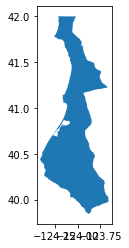

In [11]:
fz_df[fz_df.STATE_ZONE=='CA201'].plot()

In [12]:
fz_df = fz_df.drop_duplicates(subset=['STATE_ZONE'], keep='first')
fz_df.shape

(105, 11)

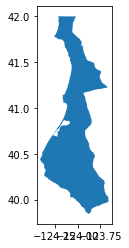

In [13]:
fz_df[fz_df.STATE_ZONE=='CA201'].plot()

In [14]:
fz_df.AREA.describe()

count    105.000000
mean       0.396442
std        0.528783
min        0.012579
25%        0.129709
50%        0.249791
75%        0.466819
max        3.918145
Name: AREA, dtype: float64

### Part 3. WildFire Perimeter Data

Source: http://frap.fire.ca.gov/data/frapgisdata-sw-fireperimeters_download

In [15]:
cal_fire_hist_df = gpd.read_file("./Data/fire18_1.gdb", layer=1)
cal_fire_hist_df.shape

(20508, 18)

In [16]:
cal_fire_hist_df = cal_fire_hist_df.to_crs({'init': 'epsg:4326'})
cal_fire_hist_df['YEAR'] = pd.to_numeric(cal_fire_hist_df.YEAR_)
cal_fire_hist_df['WF_centroid'] = cal_fire_hist_df.geometry.centroid
cal_fire_hist_df.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR,WF_centroid
0,2007,CA,CCO,LAC,OCTOBER,00246393,2007-10-21T00:00:00,2007-10-23T00:00:00,14.0,,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,(POLYGON ((-118.4985124819225 34.3824189370446...,2007.0,POINT (-118.4966070822685 34.38164004676231)
1,2007,CA,CCO,LAC,MAGIC,00233077,2007-10-22T00:00:00,2007-10-25T00:00:00,14.0,,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,(POLYGON ((-118.5844782794717 34.4197766738174...,2007.0,POINT (-118.6196283034244 34.40506739806646)
2,2007,CA,USF,ANF,RANCH,00000166,2007-10-20T00:00:00,2007-11-15T00:00:00,2.0,,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,(POLYGON ((-118.7564468802518 34.5965130520924...,2007.0,POINT (-118.7570477469558 34.49917339146693)
3,2007,CA,CCO,LAC,EMMA,00201384,2007-09-11T00:00:00,2007-09-11T00:00:00,14.0,,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,(POLYGON ((-118.0727716195954 34.5019812566583...,2007.0,POINT (-118.0632837969354 34.50614114521518)
4,2007,CA,CCO,LAC,CORRAL,00259483,2007-11-24T00:00:00,2007-11-27T00:00:00,14.0,,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,(POLYGON ((-118.7440804532698 34.0812976688129...,2007.0,POINT (-118.7480282080506 34.05551499821119)


Check how different Area metrics are 

In [17]:
cal_fire_hist_df.GIS_ACRES[1] / cal_fire_hist_df.GIS_ACRES[0]

109.7606035520938

In [18]:
cal_fire_hist_df.Shape_Area[1] / cal_fire_hist_df.Shape_Area[0]

109.7606073918841

In [19]:
cal_fire_hist_df.geometry[1].area / cal_fire_hist_df.geometry[0].area

109.79076718684776

In [20]:
cal_fire_hist_df.GIS_ACRES[0] / cal_fire_hist_df.geometry[0].area

2520998.928524572

In [21]:
cal_fire_hist_df.GIS_ACRES[1] / cal_fire_hist_df.geometry[1].area

2520306.3157225708

In [22]:
cal_fire_hist_df.GIS_ACRES[2] / cal_fire_hist_df.geometry[2].area

2517519.0375536312

### Part 4. Check overlap of WildFires and FireZones

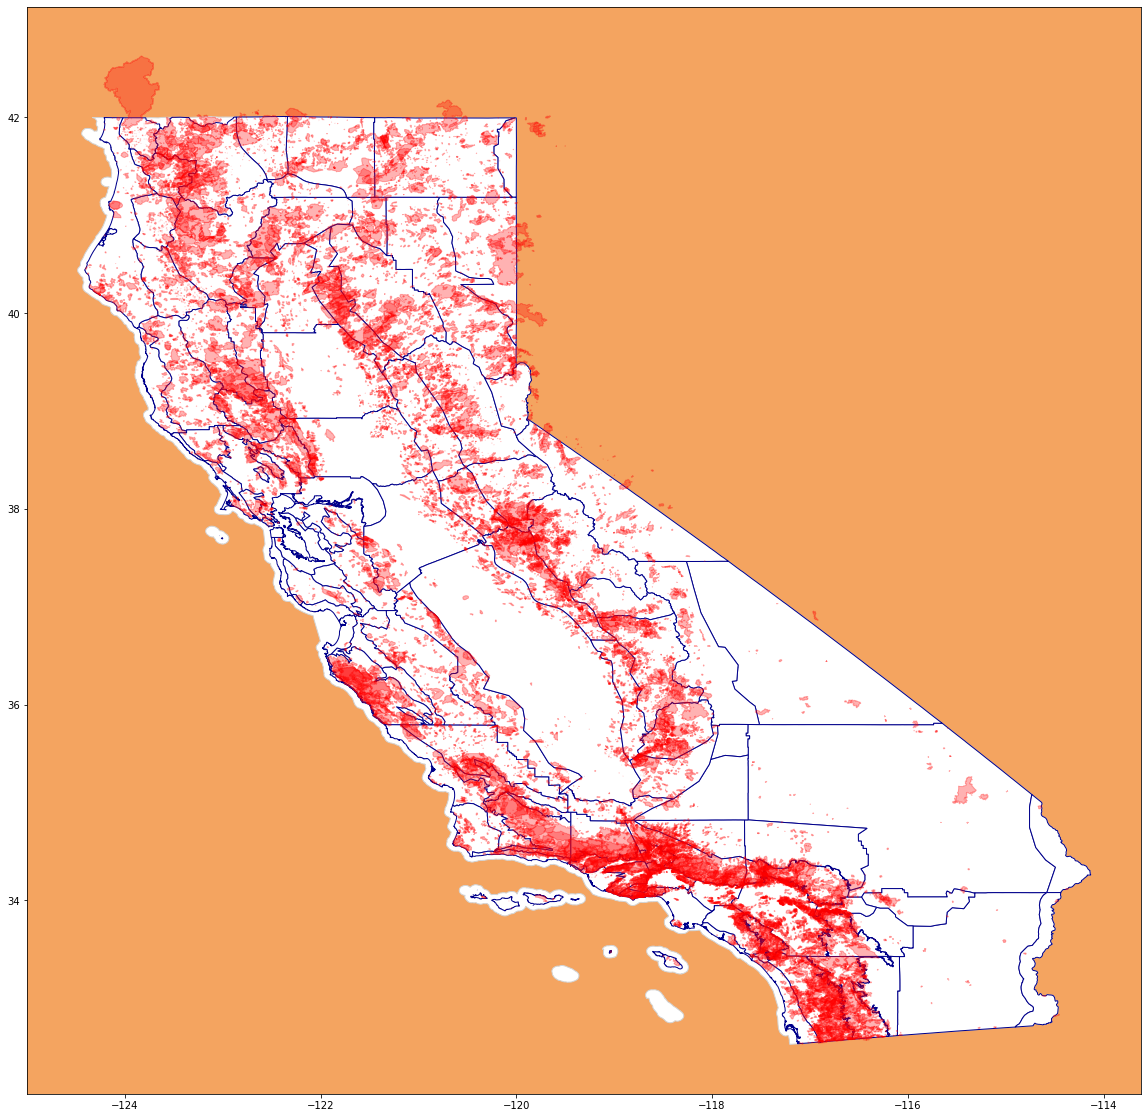

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
fz_df.plot(ax=ax, color='white', edgecolor='darkblue')
cal_fire_hist_df.plot(ax=ax, color='red', edgecolor='red', alpha=0.3)
plt.show()

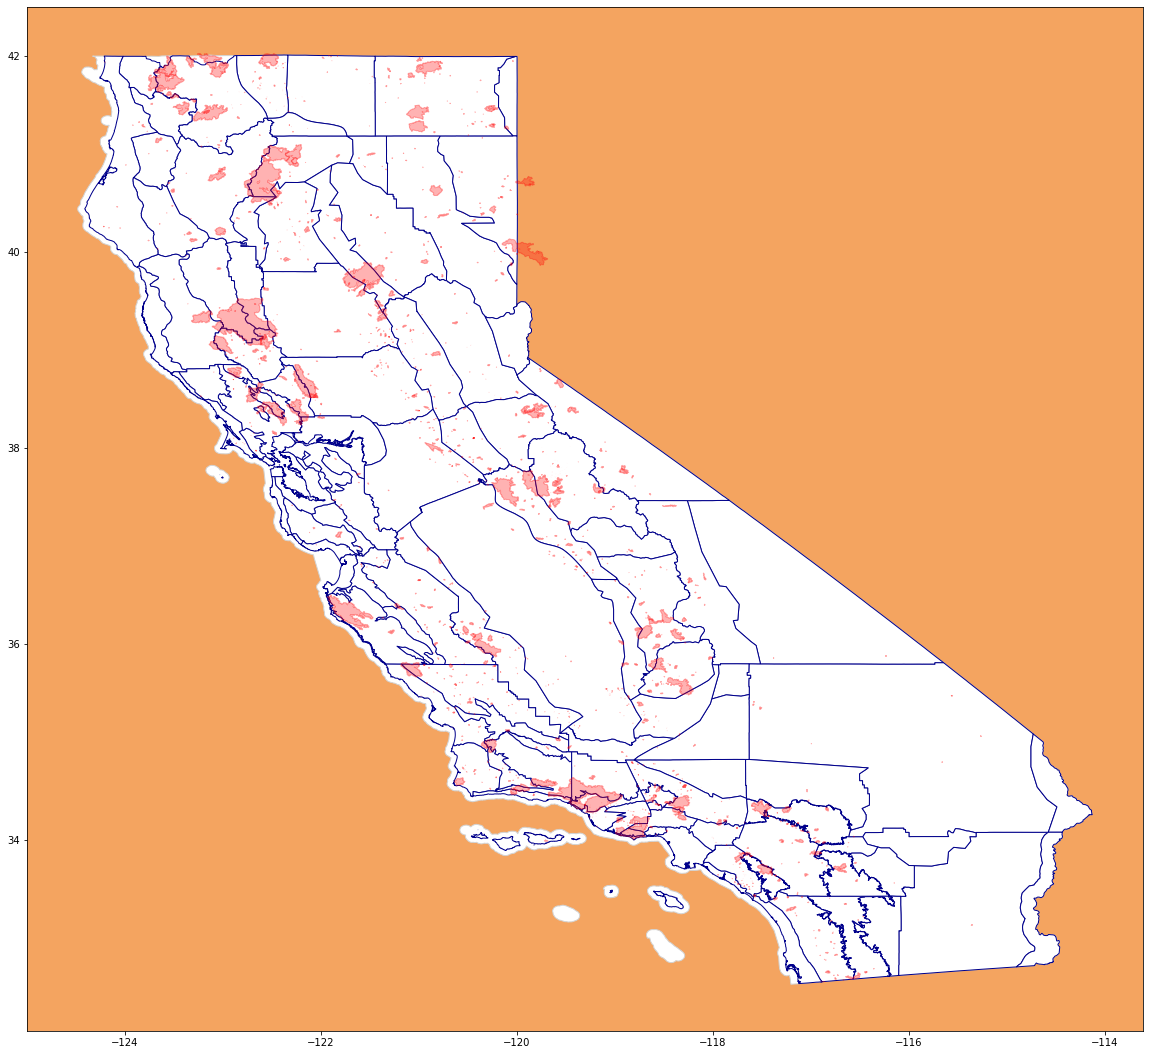

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
fz_df.plot(ax=ax, color='white', edgecolor='darkblue')
cal_fire_hist_df[cal_fire_hist_df.YEAR>=2016].plot(ax=ax, color='red', edgecolor='red', alpha=0.3)
plt.show()

In [25]:
cal_fire_hist_df.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR,WF_centroid
0,2007,CA,CCO,LAC,OCTOBER,00246393,2007-10-21T00:00:00,2007-10-23T00:00:00,14.0,,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,(POLYGON ((-118.4985124819225 34.3824189370446...,2007.0,POINT (-118.4966070822685 34.38164004676231)
1,2007,CA,CCO,LAC,MAGIC,00233077,2007-10-22T00:00:00,2007-10-25T00:00:00,14.0,,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,(POLYGON ((-118.5844782794717 34.4197766738174...,2007.0,POINT (-118.6196283034244 34.40506739806646)
2,2007,CA,USF,ANF,RANCH,00000166,2007-10-20T00:00:00,2007-11-15T00:00:00,2.0,,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,(POLYGON ((-118.7564468802518 34.5965130520924...,2007.0,POINT (-118.7570477469558 34.49917339146693)
3,2007,CA,CCO,LAC,EMMA,00201384,2007-09-11T00:00:00,2007-09-11T00:00:00,14.0,,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,(POLYGON ((-118.0727716195954 34.5019812566583...,2007.0,POINT (-118.0632837969354 34.50614114521518)
4,2007,CA,CCO,LAC,CORRAL,00259483,2007-11-24T00:00:00,2007-11-27T00:00:00,14.0,,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,(POLYGON ((-118.7440804532698 34.0812976688129...,2007.0,POINT (-118.7480282080506 34.05551499821119)


In [26]:
# def WF_in_FZ(geometry):
#     wf_count = 0
#     for wf in cal_fire_hist_df.WF_centroid:
#         if geometry.contains(wf):
#             wf_count += 1
#     return wf_count

In [27]:
def WF_in_FZ(geometry):
    """
    Checks if a fire zone contains any wildfires from the target period
    and aggreages their acreage
    """
    # subset wild fire data to 2016-2018
    df = cal_fire_hist_df[cal_fire_hist_df.YEAR >= 2016].reset_index()
    wf_area = 0
    for i in range(df.shape[0]):
        if geometry.contains(df.WF_centroid[i]):
            wf_area += df.GIS_ACRES[i]
    return wf_area

In [28]:
start = time.time()
fz_df['WF_cum_area'] = fz_df.geometry.apply(WF_in_FZ)
print(time.time()-start)

4.878122329711914


In [29]:
fz_df.head()

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA,WF_cum_area
0,CA,227,VEF,Death Valley National Park,CA227,P,ee,-117.1739,36.4677,"POLYGON ((-117.83379364 37.46531295800003, -11...",2.001602,37.487592
1,CA,270,REV,Surprise Valley California,CA270,P,nn,-120.0862,41.6116,"POLYGON ((-119.999298096 41.87491226200007, -1...",0.129737,2129.542269
2,CA,204,EKA,Lower Middle Klamath,CA204,P,nn,-123.5768,41.4252,"POLYGON ((-123.839914734 41.61329417200005, -1...",0.190186,27852.654922
3,CA,203,EKA,Upper Smith,CA203,P,nw,-123.8421,41.8153,"POLYGON ((-123.82119751 41.99661254900008, -12...",0.122278,0.000000
4,CA,211,EKA,Hupa,CA211,P,nw,-123.6867,40.9507,"POLYGON ((-123.478254949 41.10219645100005, -1...",0.202920,3788.961811


In [30]:
fz_df.WF_cum_area.describe()

count       105.000000
mean      32620.822748
std       70094.750067
min           0.000000
25%         210.879272
50%        3384.047358
75%       26451.033026
max      411287.765301
Name: WF_cum_area, dtype: float64

In [31]:
fz_df['WF_pct_area'] = fz_df.WF_cum_area / fz_df.AREA
fz_df['WF_pct_area'].describe()

count    1.050000e+02
mean     1.253122e+05
std      4.123639e+05
min      0.000000e+00
25%      8.472658e+02
50%      1.249497e+04
75%      9.047827e+04
max      3.771324e+06
Name: WF_pct_area, dtype: float64

### Part 5. Group Fire Zones by how many acres of Wild Fires they had

In [32]:
conditions = [
    (fz_df['WF_pct_area'] < 1000),
    (fz_df['WF_pct_area'] >= 1000) & (fz_df['WF_pct_area'] < 100000),
    (fz_df['WF_pct_area'] >= 100000)]
choices = ['low', 'med', 'high']
fz_df['FZ_grp'] = np.select(conditions, choices)
fz_df['FZ_grp'].value_counts()

med     51
low     28
high    26
Name: FZ_grp, dtype: int64

In [33]:
# conditions = [
#     (fz_df['WF_per_area'] < 300),
#     (fz_df['WF_per_area'] >= 300) & (fz_df['WF_per_area'] < 900),
#     (fz_df['WF_per_area'] >= 900)]
# choices = ['low', 'med', 'high']
# fz_df['FZ_grp'] = np.select(conditions, choices)
# fz_df['FZ_grp'].value_counts()

In [34]:
# pd.crosstab(fz_df['FZ_grp'], fz_df['FZ_grp2'])

#### All Historical Wild Fires

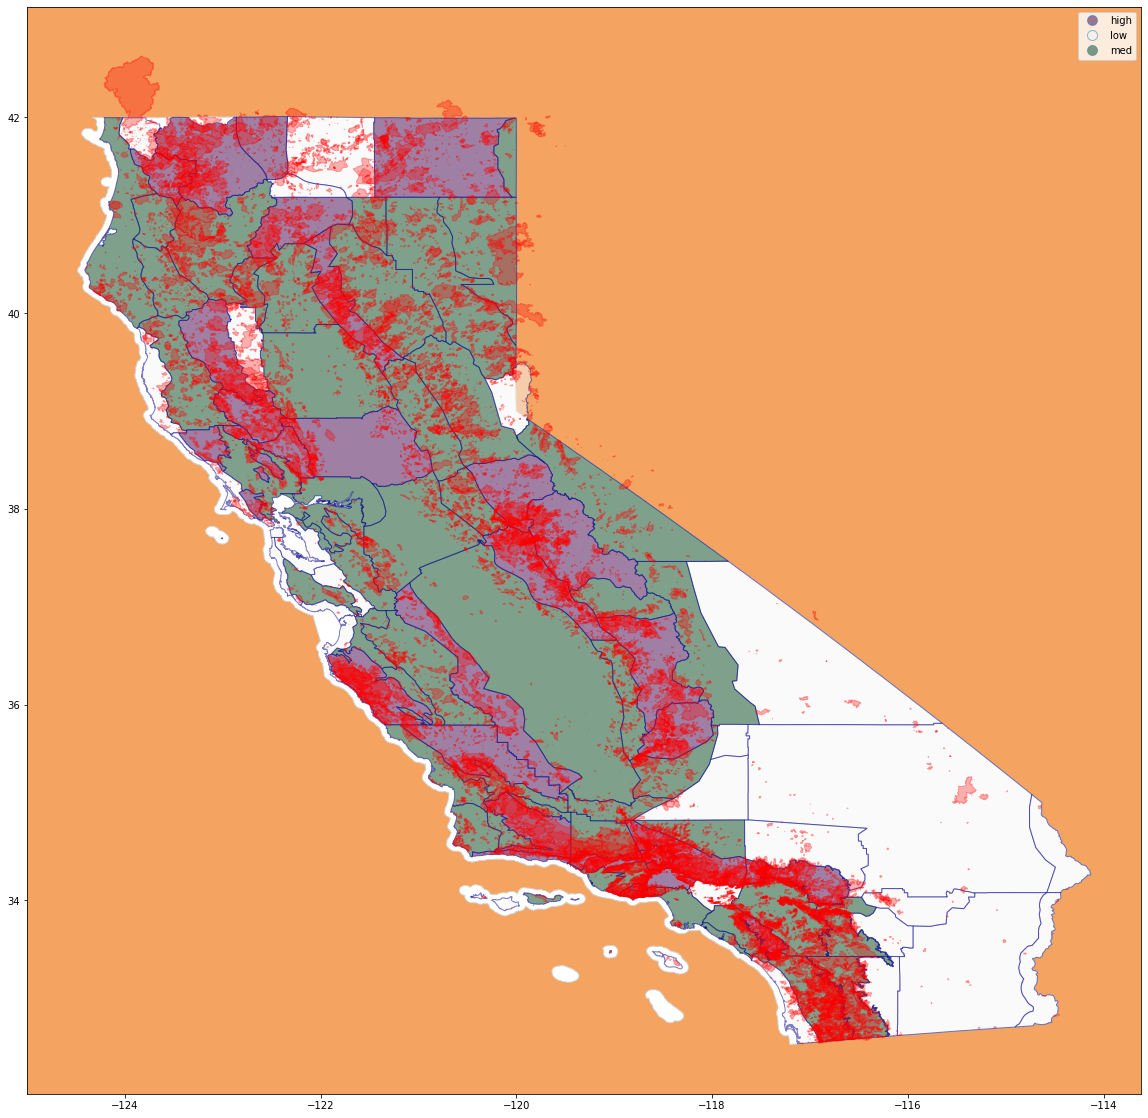

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
fz_df.plot(ax=ax, column='FZ_grp', edgecolor='darkblue', cmap='PRGn', legend=True, alpha=0.5)
cal_fire_hist_df.plot(ax=ax, color='red', edgecolor='red', alpha=0.3)
plt.show()

#### Wild Fires 2016-2016

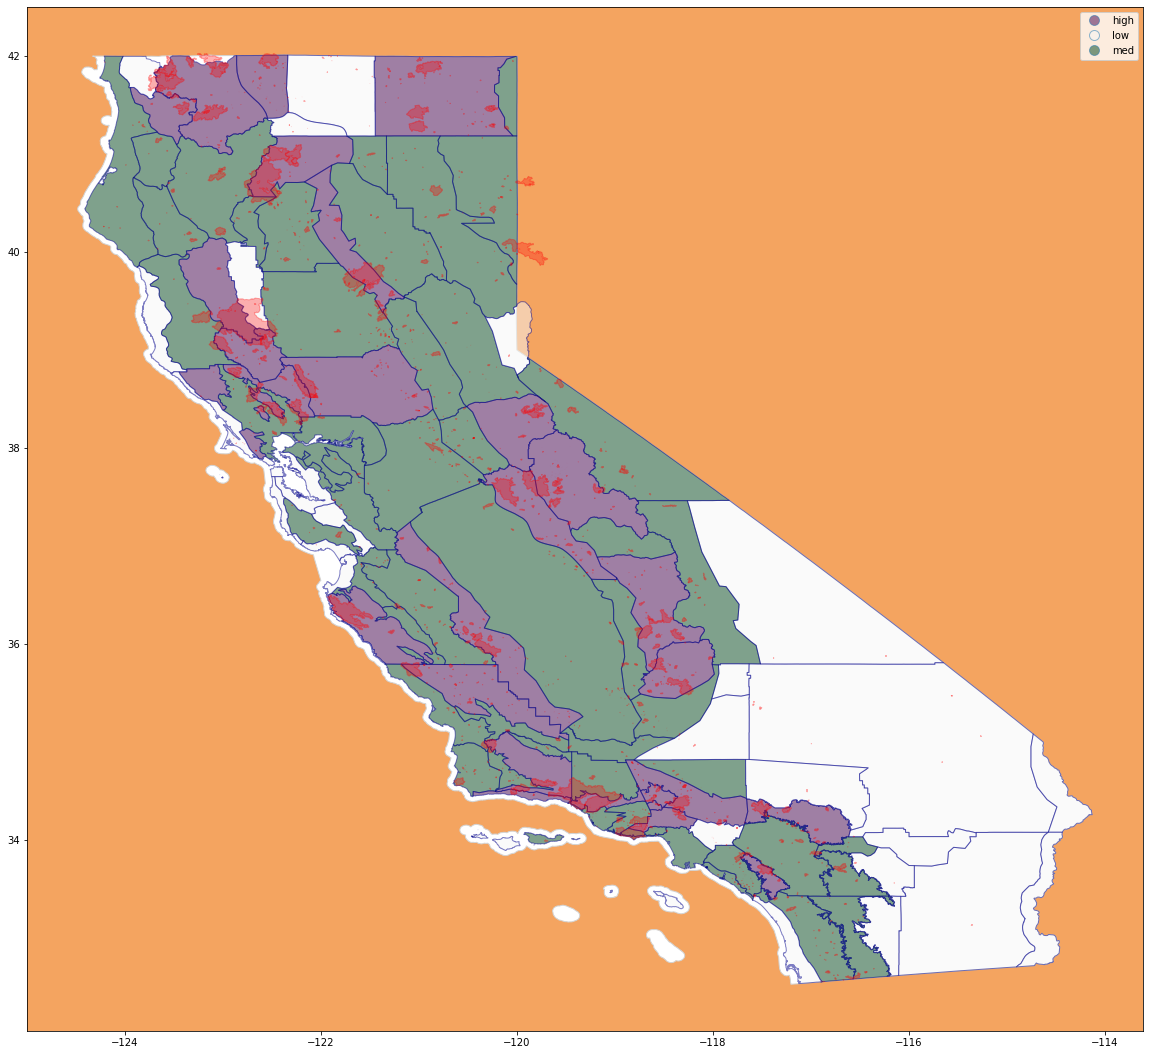

In [36]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
fz_df.plot(ax=ax, column='FZ_grp', edgecolor='darkblue', cmap='PRGn', legend=True, alpha=0.5)
cal_fire_hist_df[cal_fire_hist_df.YEAR>=2016].plot(ax=ax, color='red', edgecolor='red', alpha=0.3)
plt.show()

#### QA'ing particular Fire Zones

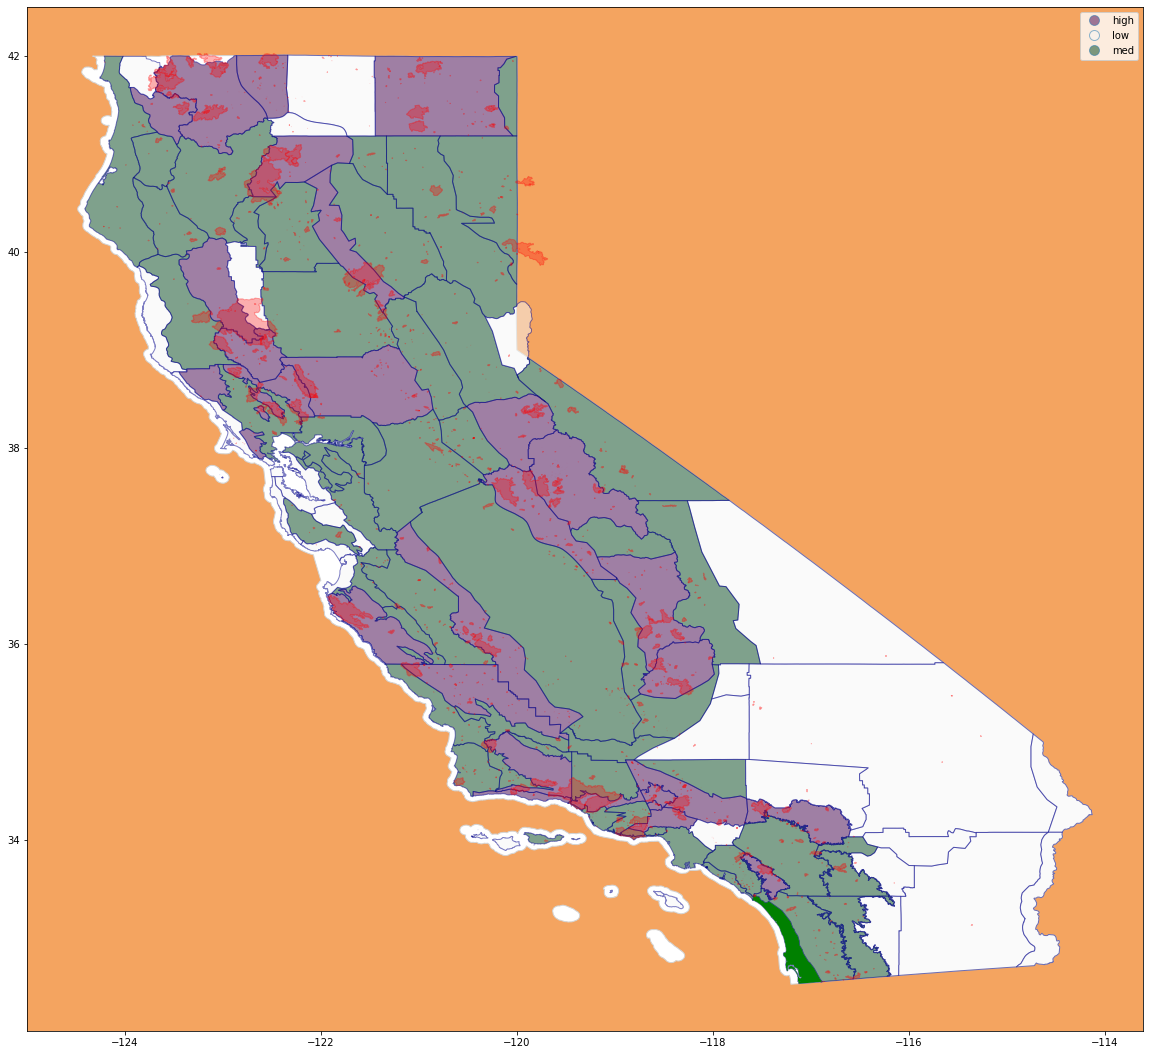

In [37]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
fz_df.plot(ax=ax, column='FZ_grp', edgecolor='darkblue', cmap='PRGn', legend=True, alpha=0.5)
fz_df[fz_df.STATE_ZONE=='CA243'].plot(ax=ax, color='green')
cal_fire_hist_df[cal_fire_hist_df.YEAR>=2016].plot(ax=ax, color='red', edgecolor='red', alpha=0.3)
plt.show()

### Part 6. Fire Zones to S2 Cells

In [38]:
poly_check = [mapping(geom)['type'] for geom in fz_df.geometry]
len(poly_check)

105

In [39]:
mp_idx = [i for i in range(len(poly_check)) if poly_check[i] == 'MultiPolygon']
len(mp_idx)

20

In [40]:
fz_df.iloc[mp_idx]

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA,WF_cum_area,WF_pct_area,FZ_grp
21,CA,202,EKA,Coastal Mendocino,CA202,P,nw,-123.6654,39.2753,"(POLYGON ((-123.644286 38.84345700000006, -123...",0.178207,0.000000,0.000000,low
26,CA,507,MTR,North Bay Mountains,CA507,P,ww,-122.6939,38.5515,"(POLYGON ((-122.733299255 38.19281387300003, -...",0.372501,166062.616953,445804.324206,high
27,CA,506,MTR,North Bay Interior Valleys,CA506,P,ww,-122.6419,38.3698,"(POLYGON ((-122.422485351 37.86712646500007, -...",0.307249,2706.154824,8807.680688,med
28,CA,505,MTR,Coastal North Bay Including Point Reyes Nation...,CA505,P,ww,-122.9543,38.2364,"(POLYGON ((-122.68067418 37.91352314100004, -1...",0.096167,11.970051,124.471828,low
29,CA,218,STO,Eastern Delta,CA218,P,cc,-121.7622,38.1433,"(POLYGON ((-121.57989502 38.33001327500006, -1...",0.249791,2225.472359,8909.324866,med
31,CA,510,MTR,East Bay Interior Valleys,CA510,P,ww,-121.8801,37.8804,"(POLYGON ((-121.582261 38.09491700000007, -121...",0.180711,632.328125,3499.113298,med
34,CA,508,MTR,San Francisco Bay Shoreline,CA508,P,ww,-122.1650,37.5938,"(POLYGON ((-122.427848816 37.96555709800003, -...",0.143178,0.000000,0.000000,low
42,CA,509,MTR,San Fransisco Peninsula Coast,CA509,P,ww,-122.3923,37.3740,"(POLYGON ((-122.338095149 37.10970664100006, -...",0.043589,0.000000,0.000000,low
45,CA,530,MTR,Southern Monterey Bay and Big Sur Coast,CA530,P,ww,-121.7566,36.6165,"(POLYGON ((-121.453315 35.87534400000004, -121...",0.071149,0.000000,0.000000,low
47,CA,234,LOX,San Luis Obispo County Central Coast,CA234,P,sw,-120.7407,35.3270,"(POLYGON ((-121.349632263 35.79776763900003, -...",0.230349,828.814330,3598.086553,med


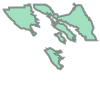

In [41]:
fz_df.loc[26,'geometry']

In [42]:
def create_S2_loop(geometry):
    """Creates a list of S2 Loop for polygons/multipolygons"""
    s2_loops = []
    mapping_dict = mapping(geometry)
    coords = mapping_dict['coordinates']
    if mapping_dict['type']=='Polygon':
        points = []
        for coord in tuple(reversed(coords[0])):
            long, lat = coord
            latlng = s2.S2LatLng.FromDegrees(lat, long)
            points.append(latlng.ToPoint())        
        s2_loops.append(s2.S2Loop(points))
    elif mapping_dict['type']=='MultiPolygon':
        for coord in coords:
            points = []
            for subcoord in tuple(reversed(coord[0])):
                long, lat = subcoord
                latlng = s2.S2LatLng.FromDegrees(lat, long)
                points.append(latlng.ToPoint())
            s2_loops.append(s2.S2Loop(points))
    return s2_loops

In [43]:
fz_df['FZ_S2_Loop'] = fz_df.geometry.apply(create_S2_loop)
fz_df.head()

,STATE,ZONE,CWA,NAME,STATE_ZONE,TIME_ZONE,FE_AREA,LON,LAT,geometry,AREA,WF_cum_area,WF_pct_area,FZ_grp,FZ_S2_Loop
0,CA,227,VEF,Death Valley National Park,CA227,P,ee,-117.1739,36.4677,"POLYGON ((-117.83379364 37.46531295800003, -11...",2.001602,37.487592,18.728799,low,[<s2_py.pywraps2.S2Loop; proxy of <Swig Object...
1,CA,270,REV,Surprise Valley California,CA270,P,nn,-120.0862,41.6116,"POLYGON ((-119.999298096 41.87491226200007, -1...",0.129737,2129.542269,16414.263246,med,[<s2_py.pywraps2.S2Loop; proxy of <Swig Object...
2,CA,204,EKA,Lower Middle Klamath,CA204,P,nn,-123.5768,41.4252,"POLYGON ((-123.839914734 41.61329417200005, -1...",0.190186,27852.654922,146449.679769,high,[<s2_py.pywraps2.S2Loop; proxy of <Swig Object...
3,CA,203,EKA,Upper Smith,CA203,P,nw,-123.8421,41.8153,"POLYGON ((-123.82119751 41.99661254900008, -12...",0.122278,0.000000,0.000000,low,[<s2_py.pywraps2.S2Loop; proxy of <Swig Object...
4,CA,211,EKA,Hupa,CA211,P,nw,-123.6867,40.9507,"POLYGON ((-123.478254949 41.10219645100005, -1...",0.202920,3788.961811,18672.209704,med,[<s2_py.pywraps2.S2Loop; proxy of <Swig Object...


In [44]:
def split_data_frame_list(df, target_column, row_id):
    """
    Splits a column with lists into rows
    
    Keyword arguments:
        df -- dataframe
        target_column -- name of column that contains lists        
    """
    
    # create a new dataframe with each item in a seperate column, dropping rows with missing values
    col_df = pd.DataFrame(df[target_column].tolist())\
                .join(df)\
                .drop(columns=[target_column])\
                .set_index(row_id)

    # create a series with columns stacked as rows         
    stacked = col_df.stack()\
                    .reset_index()\
                    .drop(columns='level_1')
    stacked.columns = [row_id, target_column]

    return stacked

In [45]:
fz_df.STATE_ZONE.nunique()

105

In [46]:
fz_s2_df = fz_df[['STATE_ZONE', 'FZ_S2_Loop']]
fz_s2_df = split_data_frame_list(fz_s2_df, 'FZ_S2_Loop', 'STATE_ZONE')
fz_s2_df.shape

(275, 2)

In [47]:
fz_s2_df.head()

,STATE_ZONE,FZ_S2_Loop
0,CA227,<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...
1,CA270,<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...
2,CA204,<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...
3,CA203,<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...
4,CA211,<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...


In [48]:
def create_S2_coverer(loop, lvl):
    """Generates a list of S2 Cells of specified level"""
    coverer = s2.S2RegionCoverer()
    coverer.set_min_level(lvl)
    coverer.set_max_level(lvl)
    return coverer.GetCovering(loop)

In [49]:
fz_s2_df['S2_Cells_low'] = fz_s2_df.FZ_S2_Loop.apply(create_S2_coverer, args=[9])
fz_s2_df['S2_Cells_med'] = fz_s2_df.FZ_S2_Loop.apply(create_S2_coverer, args=[10])
fz_s2_df['S2_Cells_high'] = fz_s2_df.FZ_S2_Loop.apply(create_S2_coverer, args=[11])

In [50]:
fz_s2_low_df = fz_s2_df[['STATE_ZONE', 'S2_Cells_low']]
fz_s2_low_df = split_data_frame_list(fz_s2_low_df, 'S2_Cells_low', 'STATE_ZONE')
fz_s2_low_df['S2_Cells_ID'] = fz_s2_low_df.S2_Cells_low.apply(lambda x: x.ToToken())
fz_s2_low_df['FZ_grp'] = 'low'
fz_s2_low_df.head()

,STATE_ZONE,S2_Cells_low,S2_Cells_ID,FZ_grp
0,CA227,4/001130110 ,80b8a4,low
1,CA227,4/001130111 ,80b8ac,low
2,CA227,4/001130112 ,80b8b4,low
3,CA227,4/001133020 ,80be44,low
4,CA227,4/001133021 ,80be4c,low


In [51]:
fz_s2_med_df = fz_s2_df[['STATE_ZONE', 'S2_Cells_med']]
fz_s2_med_df = split_data_frame_list(fz_s2_med_df, 'S2_Cells_med', 'STATE_ZONE')
fz_s2_med_df['S2_Cells_ID'] = fz_s2_med_df.S2_Cells_med.apply(lambda x: x.ToToken())
fz_s2_med_df['FZ_grp'] = 'med'
fz_s2_med_df.head()

,STATE_ZONE,S2_Cells_med,S2_Cells_ID,FZ_grp
0,CA227,4/0011301103 ,80b8a7,med
1,CA227,4/0011301110 ,80b8a9,med
2,CA227,4/0011301111 ,80b8ab,med
3,CA227,4/0011301112 ,80b8ad,med
4,CA227,4/0011301113 ,80b8af,med


In [52]:
fz_s2_high_df = fz_s2_df[['STATE_ZONE', 'S2_Cells_high']]
fz_s2_high_df = split_data_frame_list(fz_s2_high_df, 'S2_Cells_high', 'STATE_ZONE')
fz_s2_high_df['S2_Cells_ID'] = fz_s2_high_df.S2_Cells_high.apply(lambda x: x.ToToken())
fz_s2_high_df['FZ_grp'] = 'high'
fz_s2_high_df.head()

,STATE_ZONE,S2_Cells_high,S2_Cells_ID,FZ_grp
0,CA227,4/00113011030 ,80b8a64,high
1,CA227,4/00113011032 ,80b8a74,high
2,CA227,4/00113011033 ,80b8a7c,high
3,CA227,4/00113011100 ,80b8a84,high
4,CA227,4/00113011101 ,80b8a8c,high


In [53]:
fz_s2_low_df.shape, fz_s2_med_df.shape, fz_s2_high_df.shape

((2986, 4), (8669, 4), (28754, 4))

### Part 7. Final California S2 Cell file

In [54]:
keep_cols = [
    'CWA',
    'NAME',
    'STATE_ZONE',
    'FE_AREA',
    'AREA',
    'WF_cum_area',
    'FZ_grp'
]

In [55]:
ca_s2_df = fz_df[keep_cols]
ca_s2_low_df = pd.merge(ca_s2_df[ca_s2_df.FZ_grp=='low'], fz_s2_low_df[['STATE_ZONE', 'FZ_grp', 'S2_Cells_ID']], on=['STATE_ZONE','FZ_grp'], how='left')
ca_s2_med_df = pd.merge(ca_s2_df[ca_s2_df.FZ_grp=='med'], fz_s2_med_df[['STATE_ZONE', 'FZ_grp', 'S2_Cells_ID']], on=['STATE_ZONE','FZ_grp'], how='left')
ca_s2_high_df = pd.merge(ca_s2_df[ca_s2_df.FZ_grp=='high'], fz_s2_high_df[['STATE_ZONE', 'FZ_grp', 'S2_Cells_ID']], on=['STATE_ZONE','FZ_grp'], how='left')
ca_s2_low_df.shape, ca_s2_med_df.shape, ca_s2_high_df.shape

((814, 8), (4247, 8), (6935, 8))

In [56]:
ca_s2_df = ca_s2_low_df.append(ca_s2_med_df).append(ca_s2_high_df)
ca_s2_df.shape

(11996, 8)

In [57]:
ca_s2_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c


In [58]:
# there are duplicates since some fire zones consisted of multiple polygons
# that were close enough to fall into the same cell
ca_s2_df.S2_Cells_ID.nunique()

10643

In [59]:
ca_s2_df[ca_s2_df.duplicated(subset='S2_Cells_ID')].head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID
154,EKA,Coastal Mendocino,CA202,nw,0.178207,0.000000,low,80811c
155,EKA,Coastal Mendocino,CA202,nw,0.178207,0.000000,low,808124
170,MTR,Coastal North Bay Including Point Reyes Nation...,CA505,ww,0.096167,11.970051,low,808594
174,MTR,Coastal North Bay Including Point Reyes Nation...,CA505,ww,0.096167,11.970051,low,808134
175,MTR,Coastal North Bay Including Point Reyes Nation...,CA505,ww,0.096167,11.970051,low,80814c


In [60]:
ca_s2_df[ca_s2_df.S2_Cells_ID=='80811d']

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID


In [61]:
ca_s2_df = ca_s2_df.drop_duplicates(subset='S2_Cells_ID').reset_index().drop(columns='index')
ca_s2_df.shape

(10643, 8)

In [62]:
ca_s2_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c


In [63]:
ca_s2_df.FZ_grp.value_counts()

high    6546
med     3490
low      607
Name: FZ_grp, dtype: int64

In [301]:
# this is not the final file. It's only for some QA work
ca_s2_df.to_csv('./Data/Processed/CA_FZ_S2Cells.csv', index=False)

In [302]:
ca_s2_df.shape[0]*365*3

11654085

#### Creating Extra Features

In [303]:
ca_s2_df.CWA.value_counts()

STO    2357
HNX    2230
LOX    1308
MFR    1239
MTR    1003
EKA     936
SGX     565
REV     533
VEF     385
PSR      87
Name: CWA, dtype: int64

In [94]:
cwa = pd.get_dummies(ca_s2_df.CWA)
cwa.columns = ['CWA_'+i for i in cwa.columns]
cwa.head()

,CWA_EKA,CWA_HNX,CWA_LOX,CWA_MFR,CWA_MTR,CWA_PSR,CWA_REV,CWA_SGX,CWA_STO,CWA_VEF
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1


In [95]:
ca_s2_df.FE_AREA.value_counts()

cc    3568
nn    2938
sw    1489
ww    1003
nw     789
ss     610
ee     233
Name: FE_AREA, dtype: int64

In [96]:
fe_area = pd.get_dummies(ca_s2_df.FE_AREA)
fe_area.columns = ['FE_AREA_'+i for i in fe_area.columns]
fe_area.head()

,FE_AREA_cc,FE_AREA_ee,FE_AREA_nn,FE_AREA_nw,FE_AREA_ss,FE_AREA_sw,FE_AREA_ww
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [97]:
ca_s2_df.FZ_grp.value_counts()

high    6546
med     3490
low      607
Name: FZ_grp, dtype: int64

In [98]:
fz_grp = pd.get_dummies(ca_s2_df.FZ_grp)
fz_grp.columns = ['FZ_grp_'+i for i in fz_grp.columns]
fz_grp.head()

,FZ_grp_high,FZ_grp_low,FZ_grp_med
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [99]:
ca_s2_final_df = ca_s2_df.join(cwa).join(fe_area).join(fz_grp)
ca_s2_final_df.columns = ['FZ_'+i for i in ca_s2_final_df.columns]
ca_s2_final_df.rename(columns={'FZ_S2_Cells_ID': 'S2_Cells_ID'}, inplace=True)
ca_s2_final_df.shape

(10643, 28)

In [100]:
ca_s2_final_df.head().T

,0,1,2,3,4
FZ_CWA,VEF,VEF,VEF,VEF,VEF
FZ_NAME,Death Valley National Park,Death Valley National Park,Death Valley National Park,Death Valley National Park,Death Valley National Park
FZ_STATE_ZONE,CA227,CA227,CA227,CA227,CA227
FZ_FE_AREA,ee,ee,ee,ee,ee
FZ_AREA,2.0016,2.0016,2.0016,2.0016,2.0016
FZ_WF_cum_area,37.4876,37.4876,37.4876,37.4876,37.4876
FZ_FZ_grp,low,low,low,low,low
S2_Cells_ID,80b8a4,80b8ac,80b8b4,80be44,80be4c
FZ_CWA_EKA,0,0,0,0,0
FZ_CWA_HNX,0,0,0,0,0


In [339]:
list(ca_s2_final_df)

['FZ_CWA',
 'FZ_NAME',
 'FZ_STATE_ZONE',
 'FZ_FE_AREA',
 'FZ_AREA',
 'FZ_WF_cum_area',
 'FZ_FZ_grp',
 'S2_Cells_ID',
 'FZ_CWA_EKA',
 'FZ_CWA_HNX',
 'FZ_CWA_LOX',
 'FZ_CWA_MFR',
 'FZ_CWA_MTR',
 'FZ_CWA_PSR',
 'FZ_CWA_REV',
 'FZ_CWA_SGX',
 'FZ_CWA_STO',
 'FZ_CWA_VEF',
 'FZ_FE_AREA_cc',
 'FZ_FE_AREA_ee',
 'FZ_FE_AREA_nn',
 'FZ_FE_AREA_nw',
 'FZ_FE_AREA_ss',
 'FZ_FE_AREA_sw',
 'FZ_FE_AREA_ww',
 'FZ_FZ_grp_high',
 'FZ_FZ_grp_low',
 'FZ_FZ_grp_med']

#### Saving Final CA S2 Cells File

In [338]:
ca_s2_final_df.to_csv('./Data/Processed/CA_FZ_S2Cells_XTRA.csv', index=False)

#### Doing some additional QA of data

In [312]:
cal_fire_s2_stacked_df = pd.read_csv('./Data/Processed/WildFire_S2Cells_stacked.csv')
cal_fire_s2_stacked_df.shape

(7390, 16)

In [313]:
cal_fire_s2_stacked_df.head()

,FIRE_CUSTOM_ID,S2_Cells_ID,FZ_grp,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,YEAR,ALARM_DATE_DT_DT,CONT_DATE_DT_DT,FIRE_DUR,ALARM_DATE_MONTH
0,INDIAN_WELLS_2016_09_29_0,54cea4,low,NPS,BNP,14.0,0.053234,8.0,1.0,67.420823,215.429882,2016,2016-09-29,2016-09-30,2.0,9
1,PELICAN_2016_07_07_0,8085d4,low,NPS,RNP,14.0,0.498426,8.0,1.0,227.100239,2017.058906,2016,2016-07-07,2016-07-07,1.0,7
2,COAST_2016_12_02_0,80e83c,low,NPS,SMP,14.0,1.167387,8.0,1.0,461.384327,4724.249576,2016,2016-12-02,2016-12-02,1.0,12
3,LIBERTY_CANYON_2016_11_05_0,80e824,low,NPS,SMP,14.0,0.077735,8.0,1.0,63.357001,314.580697,2016,2016-11-05,2016-11-05,1.0,11
4,MULHOLLAND_2016_02_25_0,80e83c,low,NPS,SMP,14.0,11.325290,8.0,1.0,1032.685562,45831.821744,2016,2016-02-25,2016-02-28,4.0,2


In [314]:
wf_s2_df = pd.DataFrame(cal_fire_s2_stacked_df.S2_Cells_ID.unique())
wf_s2_df.columns = ['S2_Cells_ID']
wf_s2_df['WildFire'] = 1
wf_s2_df.shape

(5032, 2)

In [315]:
ca_s2_wf_df = pd.merge(ca_s2_df[['STATE_ZONE', 'FZ_grp', 'S2_Cells_ID']], wf_s2_df, on='S2_Cells_ID', how='left').fillna(0)
ca_s2_wf_df.shape

(10643, 4)

In [316]:
ca_s2_wf_df.WildFire.sum(), ca_s2_wf_df.WildFire.mean()

(2775.0, 0.26073475523818473)

### Part 8. Baseline Dataset: All CA S2 Cells + Dates for 3 years

In [324]:
# ca_s2_wf_df['WildFire_0_Sample'] = ca_s2_wf_df.WildFire.apply(lambda x: x if x == 1 else np.random.choice(2, 1, p=[0.7, 0.3])[0])
# ca_s2_wf_df.head()

In [325]:
# ca_s2_wf_df.groupby(['WildFire']).WildFire_0_Sample.sum()

In [326]:
# ca_s2_wf_df.WildFire_0_Sample.sum()

In [327]:
# ca_s2_wf_sample_df = ca_s2_wf_df[ca_s2_wf_df.WildFire_0_Sample==1]
# ca_s2_wf_sample_df.shape

In [101]:
d1 = date(2016, 1, 1)  
d2 = date(2018, 12, 31)  

delta = d2 - d1  
dates = [d1+timedelta(days=i) for i in range(delta.days+1)]
len(dates)

1096

In [328]:
# ca_s2_wf_sample_df.shape[0]*len(dates)

In [102]:
ca_s2_final_df.shape[0]*len(dates)

11664728

In [251]:
# ca_s2_wf_sample_dates_df = pd.DataFrame()
# for i in ca_s2_wf_sample_df['S2_Cells_ID']:
#     for j in dates:
#         ca_s2_wf_sample_dates_df.append([i, j])

In [107]:
with open('./Data/Processed/CA_S2_dates.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+'\n')
    for i in ca_s2_final_df['S2_Cells_ID']:
        for j in dates:
            filename.write(i+','+str(j)+'\n')

In [108]:
check = pd.read_csv('./Data/Processed/CA_S2_dates.csv', nrows=10)
check.shape

(10, 2)

In [109]:
check.head()

,S2_Cells_ID,DATE_DT_DT
0,80b8a4,2016-01-01
1,80b8a4,2016-01-02
2,80b8a4,2016-01-03
3,80b8a4,2016-01-04
4,80b8a4,2016-01-05


### Part 9. Creating CA Shapely File

In [64]:
ca_s2_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c


In [69]:
ca_s2_df.shape

(10643, 8)

In [75]:
ca_s2_df.S2_Cells_ID.nunique()

10643

In [71]:
fz_s2_low_df.head()

,STATE_ZONE,S2_Cells_low,S2_Cells_ID,FZ_grp
0,CA227,4/001130110 ,80b8a4,low
1,CA227,4/001130111 ,80b8ac,low
2,CA227,4/001130112 ,80b8b4,low
3,CA227,4/001133020 ,80be44,low
4,CA227,4/001133021 ,80be4c,low


In [84]:
fz_s2_stacked_df = fz_s2_low_df.rename(columns={'S2_Cells_low': 'S2_Cells'})\
                               .append(fz_s2_med_df.rename(columns={'S2_Cells_med': 'S2_Cells'}))\
                               .append(fz_s2_high_df.rename(columns={'S2_Cells_high': 'S2_Cells'}))
ca_s2_geom_df = pd.merge(ca_s2_df, fz_s2_stacked_df[['S2_Cells','S2_Cells_ID']], on='S2_Cells_ID', how='left')
# some cells from low-med-high are duplicated since fire zones contained multiple polygons within the same S2 Cells
ca_s2_geom_df = ca_s2_geom_df.drop_duplicates(subset='S2_Cells_ID').reset_index().drop(columns='index')
ca_s2_geom_df.shape

(10643, 9)

In [80]:
ca_s2_geom_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID,S2_Cells
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,4/001130110 
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,4/001130111 
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,4/001130112 
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,4/001133020 
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,4/001133021 


In [81]:
def S2Cells_To_Poly(s2_cell):
    """Converts S2 Cells into Polygons"""
    geoms = []
    new_cell = s2.S2Cell(s2_cell)
    vertices = []
    for i in range(4):
        vertex = new_cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append((latlng.lng().degrees(),
                         latlng.lat().degrees()))
    return Polygon(vertices)

In [85]:
ca_s2_geom_df['geometry'] = ca_s2_geom_df.S2_Cells.apply(S2Cells_To_Poly)
ca_s2_geom_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID,S2_Cells,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,4/001130110 ,POLYGON ((-116.9852421934208 36.92851788893871...
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,4/001130111 ,POLYGON ((-117.1735315927328 36.88229296981148...
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,4/001130112 ,POLYGON ((-117.1735315927328 37.04169221702246...
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,4/001133020 ,POLYGON ((-118.2994349957241 37.38986432048104...
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,4/001133021 ,POLYGON ((-118.2994349957241 37.23225420438236...


In [91]:
ca_s2_geom_gdf = gpd.GeoDataFrame(ca_s2_geom_df.drop(columns='S2_Cells'), crs={'init': 'epsg:4326'}, geometry='geometry')
ca_s2_geom_gdf.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_area,FZ_grp,S2_Cells_ID,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,POLYGON ((-116.9852421934208 36.92851788893871...
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,POLYGON ((-117.1735315927328 36.88229296981148...
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,POLYGON ((-117.1735315927328 37.04169221702246...
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,POLYGON ((-118.2994349957241 37.38986432048104...
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,POLYGON ((-118.2994349957241 37.23225420438236...


In [92]:
ca_s2_geom_gdf.to_file('./Data/Processed/CA_S2Cells/CA_S2Cells.shp', driver='ESRI Shapefile')

In [111]:
check = gpd.read_file("./Data/Processed/CA_S2Cells/CA_S2Cells.shp")
check.shape

(10643, 9)

In [112]:
check.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_are,FZ_grp,S2_Cells_I,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,POLYGON ((-116.9852421934208 36.92851788893871...
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,POLYGON ((-117.1735315927328 36.88229296981148...
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,POLYGON ((-117.1735315927328 37.04169221702246...
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,POLYGON ((-118.2994349957241 37.38986432048104...
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,POLYGON ((-118.2994349957241 37.23225420438236...


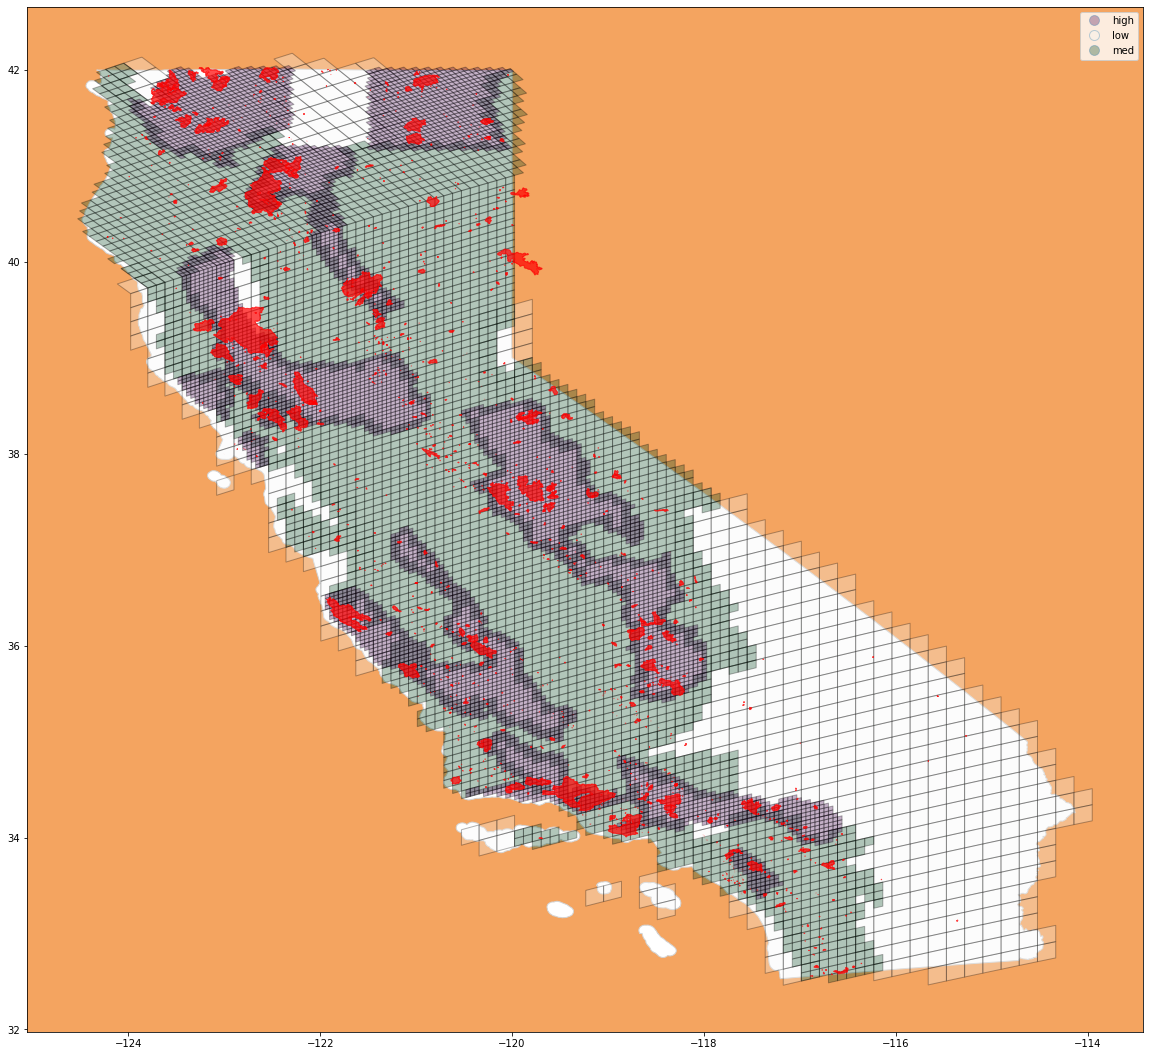

In [117]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
# fz_df.plot(ax=ax, column='FZ_grp', edgecolor='darkblue', cmap='PRGn', legend=True, alpha=0.5)
ca_s2_geom_gdf.plot(ax=ax, column='FZ_grp', cmap='PRGn', edgecolor='black', legend=True, alpha=0.3)
cal_fire_hist_df[cal_fire_hist_df.YEAR>=2016].plot(ax=ax, color='red', edgecolor='red', alpha=0.7)
plt.show()